# Pradžia  <img src="img/8aLogg.gif" align="right"/>   

   
Duomenys šiai analizei buvo paimti iš tinklapyje __kaggle.com__ patalpintos boulderingo (lipimo į uolą) entuziastų duomenų bazės, kurią sudarė David Cohen. https://www.kaggle.com/dcohen21/8anu-climbing-logbook "8a.nu Climbing Logbook". Duomenys surinkti 2017-09-13. 

## Apie duomenis

 <img src="img/iliustrac.jpg" align = "right" alt="Elizabeth Tai" title="Elizabeth Tai" width=300, height=700 />
 
 Duomenų bazė sudaryta iš boulderingo tinklapyje ___8na.nu___ esančių ir *web scrapping'o* būdu išgautų duomenų. Pradinis duomenų formatas su kuriuo darbavausi - sqlite DB, sudaryta iš 4 lentelių. Didžiausioje jų - virš 4 mln. įrašų apie dalyvio  keletu galimų būdų įveiktas trasas, esančias ant skirtingų uolų, tiek naturalių, tiek ir dirbtinių(esančių uždarose patalpose). Kiekvienas lipimas, priklausomai nuo sudėtingumo, pasirinkto būdo yra vertinamas taškais. Trasų sudėtingumas taip pat vertinamas ir pagal savo nusistovėjusią vertinimo sistemą - nuo 1 iki 9C+ / 10A (pagal Fontainebleau, dar kitaip europietiškąją sistemą) arba VB - V20 (pagal amerikietiškąją). Kitose duomenų bazės lentelėse buvo informacija apie vertinimo sistemą, kopimo būdų įvertinimus. Paskutinė duomenų bazės lentelė skirta dalyviams, kurių buvo virš 62 tūkst.
 
 Turimas sqlite failas buvo konvertuotas į PostgreSQL formatą. Kadangi duomenys gauti web scrappingo pagalba, tikėjausi, kad bus netikslumų, nepilnų įrašų. todėl prieš konvertuojant į Python analizei tinkamą CSV failą, duomenis tvarkiau, filtravau, atrinkinėjau, grupavau PostgreSQL pagalba.  
  #### Atrinkti duomenų laukai
 * Ūgis
 * Svoris
 * Gimimo data
 * Lytis
 * Pasiektas aukščiausias trasos lygis
 
#### Išvestiniai (agreguoti) duomenys
 * Visi dalyvio sukaupti taškai
 * Taškų vidurkis
 * Bendras įveiktų trasų skaičius
 * Skirtingų uolų skaičius
 * Kiek metų laipioja
 * Kokio amžiaus būdamas pradėjo laipioti

Kadangi duomenų masyvas buvo labai didelis, todėl atrinkau duomenis pagal tam tikrus kriterijus, kurie maniau būsiantys svarbūs (ar bent jau įdomūs) tolimesnei analizei. Kriterijai: validūs duomenys apie ūgį, svorį, amžių, įveiktas trasas ir surinktus taškus.
Žemiau pateikta PostgreSQL užklausa

 ```mysql
SELECT SUM(total_score) AS taskai, ROUND(AVG(total_score), 2) AS vidurkis,
COUNT(DISTINCT ascent.name) AS trasos, COUNT(DISTINCT crag_id) AS uolos, 
COUNT(DISTINCT year) AS viso_laipioja_metu, MAX(fra_boulders) AS lygis,
started - date_part('year', TO_TIMESTAMP(users.birth, 'YYYY/MM/DD HH24:MI:SS')) AS amzius_kai_pradejo,
birth, height AS ugis, weight AS svoris, sex AS lytis
FROM ascent
JOIN users ON ascent.user_id = users.id
JOIN grade ON ascent.grade_id = grade.id
WHERE total_score != 0
GROUP BY user_id, height, weight, sex, birth, started
HAVING height >= 100 AND weight > 20 AND
started - date_part('year', TO_TIMESTAMP(users.birth, 'YYYY/MM/DD HH24:MI:SS')) >= 5 AND
started - date_part('year', TO_TIMESTAMP(users.birth, 'YYYY/MM/DD HH24:MI:SS')) <= 60
ORDER BY user_id
 ```
 
 Šiai analizei atrinkti duomenys iš PostgreSQL DB eksportuoti į CSV failą. Viso 14139 duomenų eilutės.

## Projektinis darbas - tiesinė regresija

Duomenų analizei reikiamų paketų importavimas

In [59]:
import pandas as pd                                          # duomenu manipuliavimui
import numpy as np                                           # duomenu manipuliavimui
import matplotlib.pyplot as plt                              # vizualizacijai

import seaborn as sns                                        # vizualizacijai

from sklearn.preprocessing import scale                      # statistika
from sklearn.metrics import mean_squared_error, r2_score     # statistika

import statsmodels.api as sm                                 # statistika ir modeliavimas
import statsmodels.formula.api as smf                        # statistika ir modeliavimas

%matplotlib inline

Įkeliami duomenys is CSV failo. Taip pat išvedama informacija apie duomenis, patikrinama ar neliko nulinių reikšmių, išvedami pirmos 5- ios ir paskutinės 5 -ios eilutės iš duomenų lentelės.

In [60]:
df = pd.read_csv('ultimo.csv')

In [61]:
df.columns

Index(['taskai', 'vidurkis', 'trasos', 'uolos', 'viso_laipioja_metu', 'lygis',
       'amzius_kai_pradejo', 'birth', 'ugis', 'svoris', 'lytis'],
      dtype='object')

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14139 entries, 0 to 14138
Data columns (total 11 columns):
taskai                14139 non-null int64
vidurkis              14139 non-null float64
trasos                14139 non-null int64
uolos                 14139 non-null int64
viso_laipioja_metu    14139 non-null int64
lygis                 14139 non-null object
amzius_kai_pradejo    14139 non-null int64
birth                 14139 non-null object
ugis                  14139 non-null int64
svoris                14139 non-null int64
lytis                 14139 non-null int64
dtypes: float64(1), int64(8), object(2)
memory usage: 1.2+ MB


In [63]:
df.isnull().sum()

taskai                0
vidurkis              0
trasos                0
uolos                 0
viso_laipioja_metu    0
lygis                 0
amzius_kai_pradejo    0
birth                 0
ugis                  0
svoris                0
lytis                 0
dtype: int64

In [64]:
df.head()

,taskai,vidurkis,trasos,uolos,viso_laipioja_metu,lygis,amzius_kai_pradejo,birth,ugis,svoris,lytis
0,136339,649.23,192,24,8,8A,20,1976-03-10 00:00:00,177,73,0
1,47209,773.92,59,10,7,8A,22,1973-09-09 00:00:00,180,78,0
2,154620,859.00,178,32,7,8A+,17,1984-07-26 00:00:00,165,58,1
3,28806,929.23,30,11,2,8A+,22,1970-12-02 00:00:00,185,73,0
4,536906,738.52,663,92,26,8A+,27,1965-06-22 00:00:00,167,63,0


In [65]:
df.tail()

,taskai,vidurkis,trasos,uolos,viso_laipioja_metu,lygis,amzius_kai_pradejo,birth,ugis,svoris,lytis
14134,10060,914.55,11,3,1,8A,15,1994-01-03 00:00:00,185,73,0
14135,40423,748.57,54,9,2,7C+,21,1976-06-16 00:00:00,165,63,0
14136,5074,634.25,8,1,1,6C+,22,1991-04-14 00:00:00,172,73,0
14137,5630,511.82,10,1,2,7A,12,1993-10-11 00:00:00,178,78,0
14138,400,400.00,1,1,1,6A,27,1989-05-18 00:00:00,185,68,0


In [66]:
df.describe()

,taskai,vidurkis,trasos,uolos,viso_laipioja_metu,amzius_kai_pradejo,ugis,svoris,lytis
count,1.413900e+04,14139.000000,14139.000000,14139.000000,14139.000000,14139.000000,14139.000000,14139.000000,14139.000000
mean,1.110441e+05,650.740285,146.751468,15.768088,5.069948,20.674517,176.316076,68.058986,0.117194
std,1.929789e+05,179.309238,242.416125,18.314326,4.306379,6.628343,9.823843,10.103226,0.321662
min,1.000000e+00,0.500000,1.000000,1.000000,1.000000,5.000000,100.000000,40.000000,0.000000
25%,9.461500e+03,523.160000,16.000000,4.000000,2.000000,16.000000,171.000000,63.000000,0.000000
50%,3.850900e+04,653.000000,57.000000,9.000000,4.000000,20.000000,177.000000,68.000000,0.000000
75%,1.294590e+05,777.525000,175.500000,21.000000,7.000000,24.000000,182.000000,73.000000,0.000000
max,3.118591e+06,1330.000000,4239.000000,214.000000,36.000000,60.000000,255.000000,100.000000,1.000000


Duomenų analizė. Iš *Min* eilutėje esančių duomenų galima daryti prielaidą, kad analizuojami duomenys yra realūs, tvarkingi ir tinkami tolesnei statistinei analizei, modeliavimui ir prognozavimui. 
Į stulpelyje 'lytis' pateiktus skaičiavimus nekreipiam dėmesio, kadangi jame yra duomenys, kurių reikšmės yra: 0 - vyrai, 1 - moterys.

### Koreliacija

In [67]:
df.corr()

,taskai,vidurkis,trasos,uolos,viso_laipioja_metu,amzius_kai_pradejo,ugis,svoris,lytis
taskai,1.000000,0.309994,0.976081,0.839047,0.691602,-0.113880,0.028957,0.016447,-0.073933
vidurkis,0.309994,1.000000,0.222096,0.345579,0.370386,-0.389208,0.006193,-0.113700,-0.135896
trasos,0.976081,0.222096,1.000000,0.820812,0.675612,-0.067045,0.035041,0.031561,-0.063403
uolos,0.839047,0.345579,0.820812,1.000000,0.737331,-0.094079,0.021335,0.007835,-0.036845
viso_laipioja_metu,0.691602,0.370386,0.675612,0.737331,1.000000,-0.118278,0.028524,0.035714,-0.067550
amzius_kai_pradejo,-0.113880,-0.389208,-0.067045,-0.094079,-0.118278,1.000000,0.072018,0.182587,0.029669
ugis,0.028957,0.006193,0.035041,0.021335,0.028524,0.072018,1.000000,0.640648,-0.451338
svoris,0.016447,-0.113700,0.031561,0.007835,0.035714,0.182587,0.640648,1.000000,-0.499450
lytis,-0.073933,-0.135896,-0.063403,-0.036845,-0.067550,0.029669,-0.451338,-0.499450,1.000000


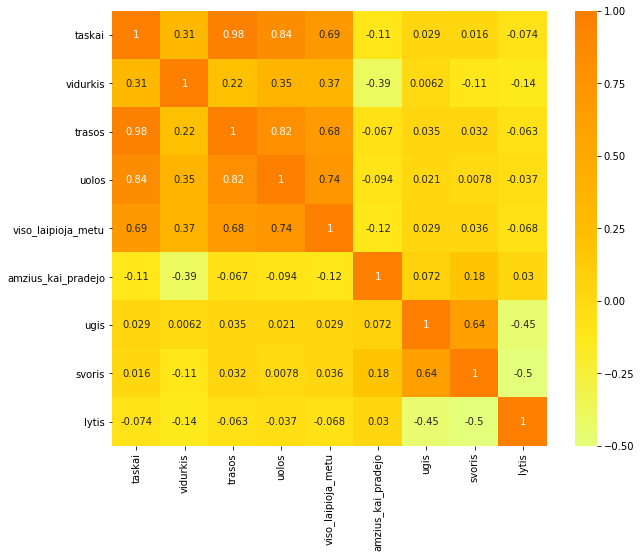

In [68]:
# Koreliacijos "heatmap'as"
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True, square=True, ax=ax)

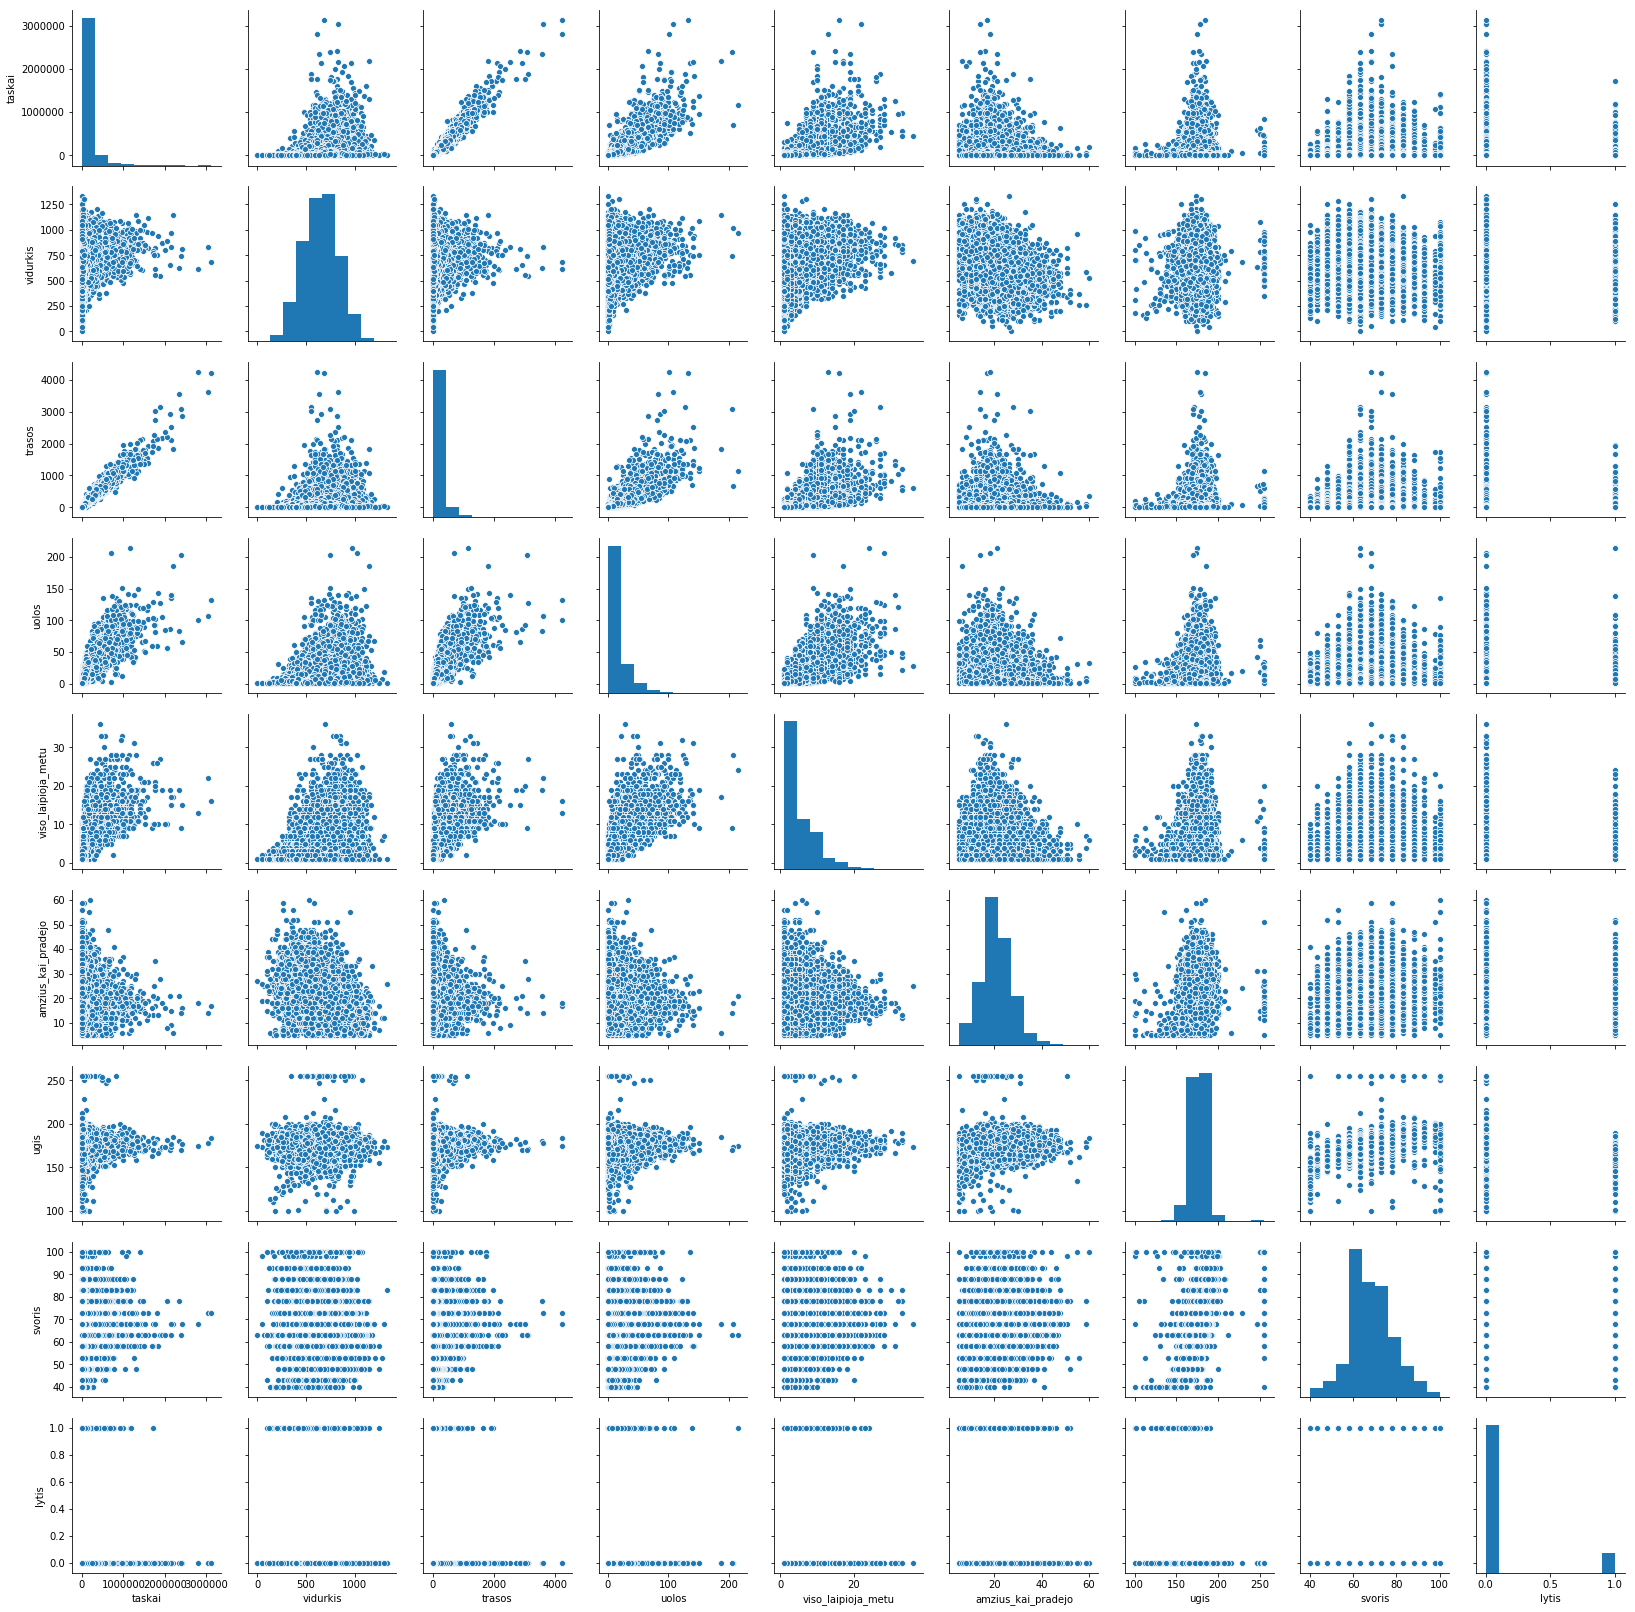

In [69]:
sns.pairplot(df)

Text(0.5, 1.0, 'Visų dalyvių taškų vidurkis ir amžius kai pradėjo laipioti')

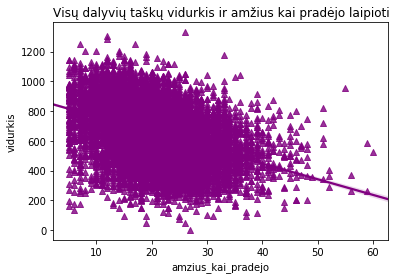

In [70]:
sns.regplot(x='amzius_kai_pradejo',y='vidurkis',data=df,marker='^',color='purple')
plt.xlabel('amzius_kai_pradejo')
plt.ylabel('vidurkis')
plt.title('Visų dalyvių taškų vidurkis ir amžius kai pradėjo laipioti')

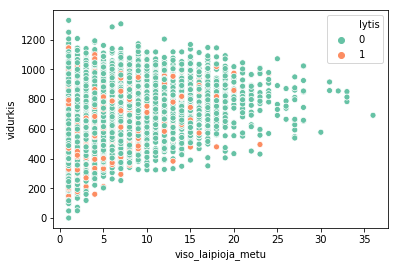

In [58]:
sns.scatterplot(x='viso_laipioja_metu', y='vidurkis', data=df, palette='Set2', hue='lytis')

Kadangi musu duomenys apima vyrus ir moteris, pateikiama informacija apie ju kieki musu duomenu lenteleje bei ivertiname ju duomenu apie laipiojimo pradžią pasiskirstymą.

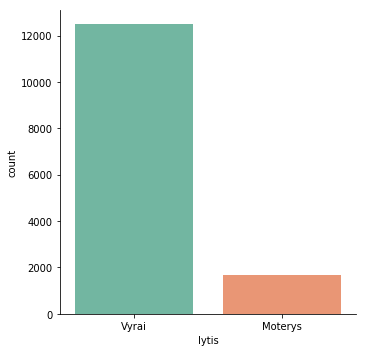

In [71]:
sns.catplot(x='lytis', kind='count', palette="Set2", data=df).set_xticklabels(["Vyrai", "Moterys"])

Text(0.5, 1.0, 'Moterų amžiaus laipiojimo  pradzioje pasiskirstymas')

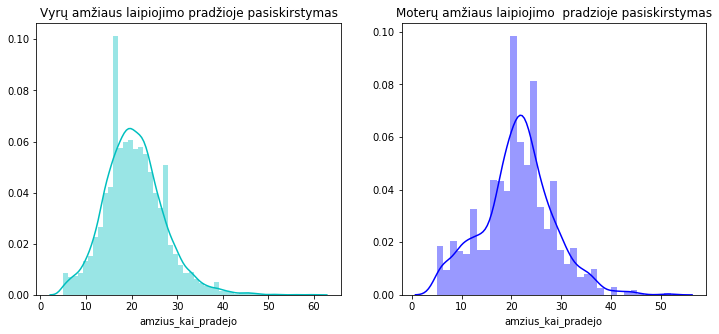

In [72]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(df[(df.lytis == 0)]['amzius_kai_pradejo'],color='c',ax=ax)
ax.set_title('Vyrų amžiaus laipiojimo pradžioje pasiskirstymas')

ax=f.add_subplot(122)
sns.distplot(df[(df.lytis == 1)]['amzius_kai_pradejo'],color='b',ax=ax)
ax.set_title('Moterų amžiaus laipiojimo  pradzioje pasiskirstymas')

####  Hipotezė
Moterų laipiojimo taškų vidurkis koreliuoja su amžiumi kada pradėjo laipioti ir kiek laiko laipioja.

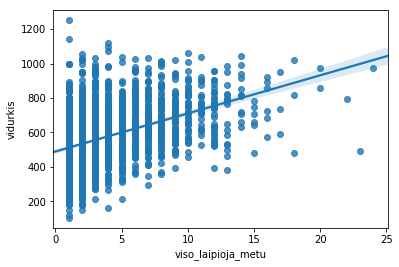

In [73]:
sns.regplot(x='viso_laipioja_metu', y='vidurkis', data=df[(df.lytis == 1)])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Moterų amžius kai pradėjo laipioti vs taškų vidurkis')

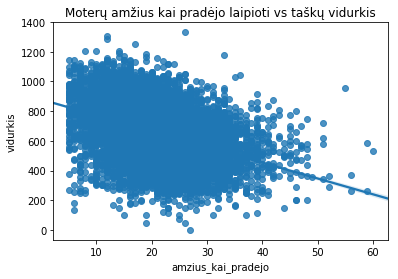

In [77]:
sns.regplot(x='amzius_kai_pradejo',y='vidurkis',data=df[(df.lytis == 0)])
plt.xlabel('amzius_kai_pradejo')
plt.ylabel('vidurkis')
plt.title('Moterų amžius kai pradėjo laipioti vs taškų vidurkis')

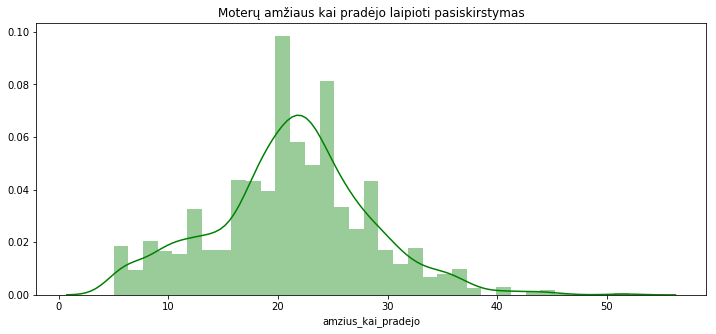

In [85]:
plt.figure(figsize=(12,5))
plt.title('Moterų amžiaus kai pradėjo laipioti pasiskirstymas')
ax = sns.distplot(df[(df.lytis == 1)]['amzius_kai_pradejo'], color = 'g')

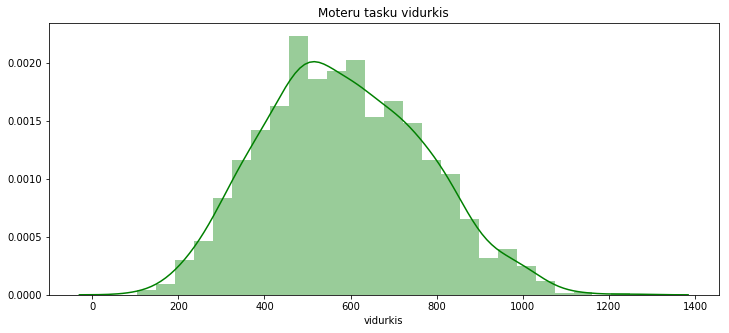

In [86]:
plt.figure(figsize=(12,5))
plt.title('Moteru tasku vidurkis')
ax = sns.distplot(df[(df.lytis == 1)]['vidurkis'], color = 'g')

In [87]:
est = smf.ols('vidurkis ~ amzius_kai_pradejo + viso_laipioja_metu', df[(df.lytis == 1)]).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               vidurkis   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     307.5
Date:                Fri, 22 Mar 2019   Prob (F-statistic):          2.84e-114
Time:                        10:57:38   Log-Likelihood:                -10745.
No. Observations:                1657   AIC:                         2.150e+04
Df Residuals:                    1654   BIC:                         2.151e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            670.8736     13.449     49.881      0.000     644.494     697.253
amzius_kai_pradejo    -8.2806      0.545    -15.196      0.000      -9.349      -7.212
viso_laipioja_metu    20.7549      1.131     18.352      0.000      18.537      22.973
==============================================================================
Omnibus:                       11.104   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.135
Skew:                           0.188   Prob(JB):                      0.00382
Kurtosis:                       3.142   Cond. No.                         78.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

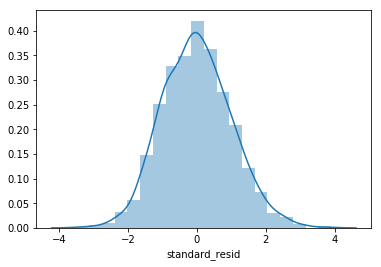

In [89]:
from statsmodels.stats.outliers_influence import OLSInfluence
std_res = OLSInfluence(est).summary_frame()
sns.distplot(std_res["standard_resid"], bins=20)

In [88]:
from sklearn.model_selection import train_test_split

x = df[(df.lytis==1)][['amzius_kai_pradejo', 'viso_laipioja_metu']]
y = df[(df.lytis==1)]['vidurkis']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state = 100)
train_set = x_train.copy()
train_set['vidurkis'] = y_train

In [82]:
est = smf.ols('vidurkis ~ amzius_kai_pradejo + viso_laipioja_metu', train_set).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               vidurkis   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     190.7
Date:                Fri, 22 Mar 2019   Prob (F-statistic):           8.44e-71
Time:                        10:56:03   Log-Likelihood:                -6438.7
No. Observations:                 994   AIC:                         1.288e+04
Df Residuals:                     991   BIC:                         1.290e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            675.1036     17.208     39.232      0.000     641.336     708.871
amzius_kai_pradejo    -8.2801      0.697    -11.888      0.000      -9.647      -6.913
viso_laipioja_metu    21.4158      1.462     14.650      0.000      18.547      24.284
==============================================================================
Omnibus:                        5.537   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                5.473
Skew:                           0.181   Prob(JB):                       0.0648
Kurtosis:                       3.039   Cond. No.                         78.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

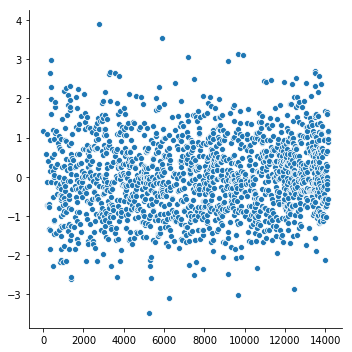

In [90]:
sns.relplot(data=std_res["standard_resid"])

In [102]:
std_res[np.abs(std_res["standard_resid"]) >3]

,dfb_Intercept,dfb_amzius_kai_pradejo,dfb_viso_laipioja_metu,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
2792,0.236586,-0.198393,-0.106292,0.018809,3.892721,0.003710,0.237542,3.909494,0.238566
5260,-0.201132,0.195767,0.022030,0.015158,-3.486666,0.003727,-0.213250,-3.498493,-0.213973
5892,-0.077949,0.139512,-0.046360,0.010061,3.540120,0.002403,0.173736,3.552534,0.174345
6263,0.144752,-0.019637,-0.418227,0.060030,-3.102753,0.018363,-0.424369,-3.110881,-0.425481
7207,0.054435,-0.016695,-0.050739,0.002796,3.062039,0.000894,0.091582,3.069827,0.091815
9667,0.208912,-0.180706,-0.086937,0.014571,3.126118,0.004453,0.209078,3.134446,0.209635
9682,-0.173295,0.151337,0.060444,0.010213,-3.008515,0.003374,-0.175042,-3.015868,-0.175470
9904,-0.259845,0.320336,0.018978,0.036005,3.109656,0.011047,0.328656,3.117843,0.329521


In [92]:
std_res[std_res["cooks_d"] > 1]

,dfb_Intercept,dfb_amzius_kai_pradejo,dfb_viso_laipioja_metu,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits


In [55]:
#
# Liekamųjų paklaidų analizė
#


# Residual Standard Error
# print('RSE:', np.sqrt(est.scale))

# Mean squared error (MSE) of the residuals. The sum of squared residuals divided by the residual degrees of freedom.
# MSE is a measure of the quality of an estimator—it is always non-negative, and values closer to zero are better.
# print('MSE:', est.mse_resid)

# Root mean square error
# RMSD is a measure of accuracy, to compare forecasting errors of different models for a particular dataset and not between datasets, as it is scale-dependent.
# print('RMSE:', np.sqrt(est.mse_resid))
# print('RMSE:', np.sqrt(sum(pow(est.resid, 2)) / (len(est.resid) - 2) ))

# Residual sum of squares (RSS) arba sum of squared residuals (SSR) arba sum of squared errors of prediction (SSE)
# A small RSS indicates a tight fit of the model to the data
# print('RSS/SSR/SSE:', est.ssr)

In [56]:
print('RMSE:', np.sqrt(est.mse_resid))

RMSE: 158.62478803486968


In [46]:
print('RSE:', np.sqrt(est.scale))

RSE: 158.62478803486968


In [48]:
est.summary().tables[2]

Omnibus:,11.104,Durbin-Watson:,1.864
Prob(Omnibus):,0.004,Jarque-Bera (JB):,11.135
Skew:,0.188,Prob(JB):,0.00382
Kurtosis:,3.142,Cond. No.,78.7


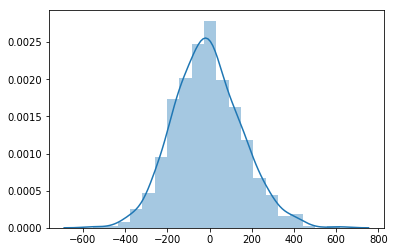

In [94]:
prediction = est.predict(x_test)
sns.distplot((y_test - prediction), bins=20)

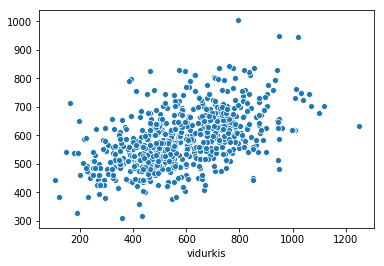

In [104]:
sns.scatterplot(x=y_test, y=prediction)

In [103]:
est.get_prediction(pd.DataFrame({'amzius_kai_pradejo': [15], 'viso_laipioja_metu': [20]})).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,961.761986,18.266044,925.934981,997.588992,648.579449,1274.944523


## Išvada

__Hipotezė__: Moterų laipiojimo taškų vidurkis koreliuoja su amžiumi kada pradėjo laipioti ir kiek laiko laipioja.

Pasirodo, kad moterų laipiojimo taškų vidurkis statistiškai reikšmingai susijęs (p<0.05) su amžiumi kuomet pradedama laipioti bei laiku praleidžiamu belaipiojant į uolas.

Su 95% tikimybe galima teigti, jog su kiekvienais metais belaipiojant į uolas, moterų surenkamų taškų vidurkis vidutiniškai padidėja 21 tašku (viso_laipioja_metu koef.:	20.7549, ci: [18.537, 22.973], a=0.05).  
Taip pat, su 95% tikimybe galima teigti, kad moterų taškų vidurkis kasmet vidutiniškai sumažėja 9 taškais (amzius_kai_pradejo koef.: -8.2806, ci: [-9.349, 7.212], a=0.05) priklausomai nuo amžiaus kuomet pradedama laipioti.


# AČIŪ UŽ DĖMESĮ !

P. S. Valhalla 9a+ possibly the hardest MP in the world https://www.8a.nu/news/valhalla-9a+-fa-by-edu-marin-304-m-roof